# Reading NYC taxi rides from Kafka using Spark Streaming

## PySpark setup

In [187]:
from pyspark.sql.session import SparkSession

from delta import *
from delta.tables import *


builder = (
    SparkSession.builder.appName("NYC_taxi_kafka")
    .config("spark.sql.extensions", 
            "io.delta.sql.DeltaSparkSessionExtension")
    .config("spark.sql.catalog.spark_catalog", 
            "org.apache.spark.sql.delta.catalog.DeltaCatalog")
    .config("spark.jars.packages", 
            "org.apache.spark:spark-sql-kafka-0-10_2.12:3.0.0")
    .config("spark.sql.repl.eagerEval.enabled", True)
)

spark = configure_spark_with_delta_pip(builder).getOrCreate()

## Define schema

In [188]:
from pyspark.sql.types import (
    StructType, StructField, StringType, IntegerType, 
    DoubleType, BooleanType, TimestampType, DateType
)

schema = StructType(
      [
        StructField("medallion",          StringType(), False),
        StructField("hack_licence",       StringType(), False),
        StructField("vendor_id",          StringType(), False),
        StructField("rate_code",          IntegerType(), False),
        StructField("store_and_fwd_flag", StringType(), False),
        StructField("pickup_datetime",    StringType(), False),
        StructField("dropoff_datetime",   StringType(), False),
        StructField("passenger_count",    IntegerType(), False),
        StructField("trip_time_in_secs",  IntegerType(), False),
        StructField("trip_distance",      DoubleType(), False),
        StructField("pickup_longitude",   DoubleType(), False),
        StructField("pickup_latitude",    DoubleType(), False),
        StructField("dropoff_longitude",  DoubleType(), False),
        StructField("dropoff_latitude",   DoubleType(), False),
        StructField("timestamp",          TimestampType(), False)
      ]
    )

## Read Kafka stream and parse JSON

Be sure to start the stream from the notebook `kafka_producer.ipynb`!

In [189]:
from pyspark.sql.functions import from_json, col

kafka_server = "kafka1:9092" 

kafka_df = (spark.readStream                        # Get the DataStreamReader
  .format("kafka")                                 # Specify the source format as "kafka"
  .option("kafka.bootstrap.servers", kafka_server) # Configure the Kafka server name and port
  .option("subscribe", "stock")                       # Subscribe to the "stock" Kafka topic 
  .option("startingOffsets", "earliest")           # The start point when a query is started
  .option("maxOffsetsPerTrigger", 100)             # Rate limit on max offsets per trigger interval
  .load() # Load the DataFrame
)

parsed_df = kafka_df.select(
    from_json(
        col("value").cast("string"), schema
    ).alias("parsed_value")
).select("parsed_value.*")

## Write data into a Delta table

In [191]:
import time, os

table_name = "taxi_rides"
checkpoint_path = "streaming/orders/_checkpoint" 
output_path = f"spark-warehouse/{table_name}"

query = (parsed_df.writeStream
  .outputMode("append")
  .format("delta")
  .queryName(f"{table_name}_query")
  .trigger(processingTime="5 second")
  .option("checkpointLocation", checkpoint_path)
  .start(output_path) 
)

# if you create the table metastore before any data exists then 
# the stream will result in an error as the table is generated with empty schema
def create_table_if_exists(output_path, table_name):
    data_exists = False
    # you can replace this with while, currently timeouts after about 60 seconds
    for _ in range(60):
        try:
            time.sleep(1)
            files = os.listdir(output_path)
            for file in files:
                if ".parquet" in file:
                    if len(os.listdir(f"{output_path}/_delta_log"))>0:
                        print("data exists")
                        data_exists = True
                        break
            if data_exists:
                # table metastore is created once there is some data (.parquet) in the directory
                spark.sql(f"CREATE TABLE IF NOT EXISTS {table_name} USING DELTA LOCATION '{table_name}'")
                break
        except Exception as e:
            print(e)

create_table_if_exists(output_path, table_name)

data exists


If you need to run the query again, you need to stop it first.

In [190]:
query.stop()

In [192]:
display(spark.table(table_name).limit(3))

medallion,hack_licence,vendor_id,rate_code,store_and_fwd_flag,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,timestamp
69F42CD1BA72F0F09...,65BABDDBC94F4C1AA...,VTS,1,,2013-01-13 10:16:00,2013-01-13 10:28:00,1,720,2.17,-73.992844,40.713799,-74.001717,40.733776,2024-06-02 12:10:11
D6B8D56A5D40E146B...,972D3BFAA5DE759A2...,VTS,2,,2013-01-13 09:57:00,2013-01-13 10:27:00,1,1800,17.61,-73.78878,40.645191,-73.992699,40.756935,2024-06-02 12:10:11
8D8BCB635B9DD8552...,CED64F99A0EB4DB33...,VTS,1,,2013-01-13 10:20:00,2013-01-13 10:31:00,1,660,1.77,-73.977867,40.751862,-73.988167,40.749813,2024-06-02 12:10:12


In [202]:
spark.table(table_name).groupBy('medallion').agg(F.count('*').alias('count'))

medallion,count
764CA5AE502C0FEC9...,4
9771700E1AE5E87B2...,2
DDB3F3E0172B1FBF0...,4
D8355B560482C567F...,1
5E162F2D7F5699497...,3
29111C0EE74A4E682...,1
4728FA63A46613319...,3
38CA8BCB4180F32BE...,2
251012565308E6E0E...,1
3AD3FD1E0FF005C66...,1


## The project starts here

You can create a

In [193]:
import pyspark.sql.functions as F
from pyspark.sql.window import Window

# Sort the dataset by medallion (taxi ID) and pickup_datetime
df = spark.table(table_name).orderBy('medallion', 'pickup_datetime')

#Calculate Idle Time
window_spec = Window.partitionBy('medallion').orderBy('pickup_datetime')
df = df.withColumn('prev_dropoff', F.lag('dropoff_datetime').over(window_spec))
df = df.withColumn('idle_time', F.unix_timestamp('pickup_datetime') - F.unix_timestamp('prev_dropoff'))
df = df.fillna(0, subset="idle_time")
df = df.withColumn("idle_time", F.when(col("idle_time") >= 14400, 0).otherwise(F.col("idle_time")))

In [180]:
#!pip install geopandas

In [194]:
import geopandas as gpd
from shapely.geometry import Point

geojson_path = 'Borough Boundaries.geojson'
gdf = gpd.read_file(geojson_path)

# Function to get borough from latitude and longitude from New York Borough Boundaries.geojson
def get_borough(lat, lon):
    point = Point(lon, lat)  # Note: Point takes (lon, lat)
    for idx, row in gdf.iterrows():
        if row['geometry'].contains(point):
            return row['boro_name']
    return None

# Register the function as a UDF
get_borough_udf = F.udf(get_borough)

# Apply the UDF to get the dropoff borough
df = df.withColumn('dropoff_borough', get_borough_udf(F.col('dropoff_latitude'), F.col('dropoff_longitude')))

# Add the pickup borough using the same UDF
df = df.withColumn('pickup_borough', get_borough_udf(F.col('pickup_latitude'), F.col('pickup_longitude')))

## [Query 1] Utilization over a window of 5, 10, and 15 minutes per taxi/driver. This can be computed by computing the idle time per taxi. How does it change? Is there an optimal window?

In [206]:
time_windows = [5, 10, 15]
max_timestamp = df.agg(F.max('timestamp')).collect()[0][0]

# Calculate idle time, passenger road time, and empty road time
has_passengers = F.when(F.col('passenger_count') > 0, 1).otherwise(0)
no_passengers = F.when(F.col('passenger_count') == 0, 1).otherwise(0)

# Initialize an empty list to store the results
results = []


# Iterate over each time window
for window in time_windows:    
    # Filter the data for the current time window
    window_df = df.filter(F.col('timestamp') >= F.lit(max_timestamp) - F.expr(f"INTERVAL {window} MINUTE"))

    window_agg = window_df.groupBy('medallion').agg(
        F.sum('idle_time').alias('idle_time'),
        F.sum(F.col('trip_time_in_secs') * has_passengers).alias('passenger_road_time'),
        F.sum(F.col('trip_time_in_secs') * no_passengers).alias('empty_road_time')
    )

    # Calculate utilization
    window_agg = window_agg.withColumn(
        'utilization',
        F.col('passenger_road_time') / (
            F.col('idle_time') + F.col('empty_road_time') + F.col('passenger_road_time')
        )
    )
    window_agg.filter(F.col('utilization') < 1.0).select("medallion", "utilization").show()

    # Calculate average utilization for the current window
    avg_utilization = window_agg.filter(F.col('utilization') < 1.0).agg(F.mean('utilization')).collect()[0][0]
    
    # Append the result to the list
    results.append((window, avg_utilization))

# Display the results
for window, avg_utilization in results:
    print(f"Average utilization for {window} minutes window: {avg_utilization}")


+--------------------+-------------------+
|           medallion|        utilization|
+--------------------+-------------------+
|12B46A3AAAEAD5086...| 0.1956521739130435|
|1CA1F43CA75E2744B...|             0.3875|
|318C8A3F7A86A2AEB...|              0.375|
|34346632EF1C76656...|0.34782608695652173|
|3A00BD8BD96A8EFF2...| 0.6363636363636364|
|6816A8A4203980A7D...|0.28888888888888886|
|69AAA9E6753311E71...| 0.4230769230769231|
|69F42CD1BA72F0F09...| 0.2807017543859649|
|77E20B11A5C1BC89F...| 0.7368421052631579|
|8B17A20F99817F975...| 0.7368421052631579|
|9771700E1AE5E87B2...| 0.5079365079365079|
|9BB934828EB711E57...| 0.3793103448275862|
|A5179D5A72336EEDF...|                0.6|
|ACBED2EC7C4E0B579...| 0.7692307692307693|
|CA2E404BE3197B507...| 0.7638888888888888|
|D22FDB926D6B57441...|0.19148936170212766|
|E0AA965A6EF756AD2...|0.21428571428571427|
|E198E8F9086B386D5...| 0.4482758620689655|
+--------------------+-------------------+

+--------------------+-------------------+
|         

## [Query 2] The average time it takes for a taxi to find its next fare(trip) per destination borough. This can be computed by finding the time difference, e.g. in seconds, between the trip's drop off and the next trip's pick up within a given unit of time

+---------------+------------------+
|dropoff_borough|     avg_idle_time|
+---------------+------------------+
|         Queens|            7002.0|
|       Brooklyn|          2005.375|
|      Manhattan|3257.0476190476193|
+---------------+------------------+



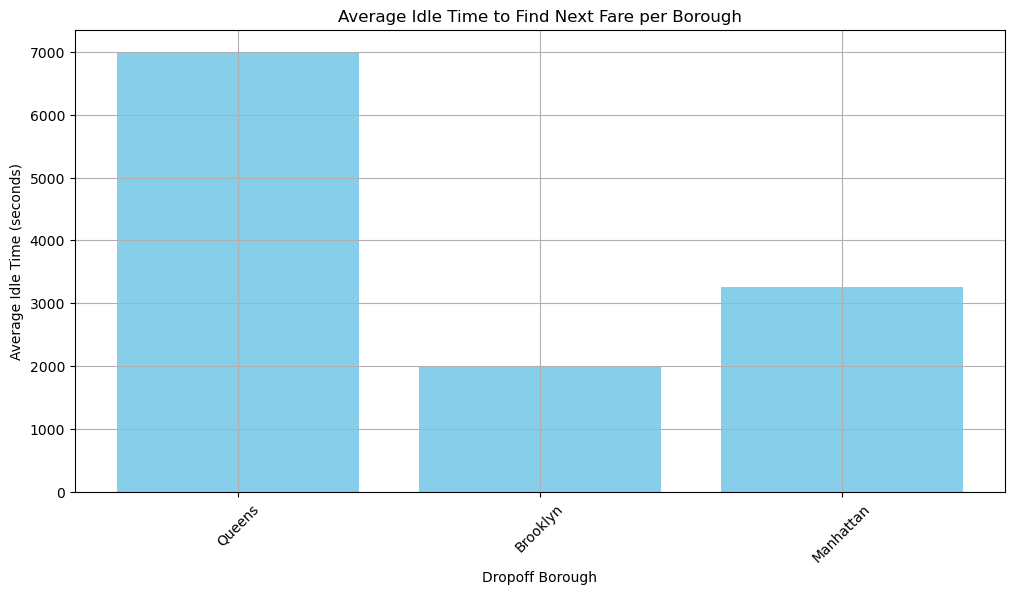

In [207]:
import pandas as pd
import matplotlib.pyplot as plt

unit_of_time = "10 MINUTE"
max_timestamp = df.agg(F.max('timestamp')).collect()[0][0]

# Group by dropoff borough and calculate the average idle time
borough_idle_time = df.filter((F.col('idle_time') > 0) & F.col('dropoff_borough').isNotNull() & (F.col('timestamp') >= F.lit(max_timestamp) - F.expr(f"INTERVAL {unit_of_time}"))
                             ).groupBy('dropoff_borough').agg(F.mean('idle_time').alias('avg_idle_time'))

# Display the results
borough_idle_time.show()

# Convert to Pandas for easier analysis and display
borough_idle_time_pdf = borough_idle_time.toPandas()

# Plotting the results
plt.figure(figsize=(12, 6))
plt.bar(borough_idle_time_pdf['dropoff_borough'], borough_idle_time_pdf['avg_idle_time'], color='skyblue')
plt.title('Average Idle Time to Find Next Fare per Borough')
plt.xlabel('Dropoff Borough')
plt.ylabel('Average Idle Time (seconds)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

## [Query 3] The number of trips that started and ended within the same borough in the last hour

In [198]:
# Filter trips that started and ended within the same borough
same_borough_trips = df.filter(F.col('pickup_borough') == F.col('dropoff_borough'))

# Filter trips in the last hour
same_borough_trips_last_hour = same_borough_trips.filter(
    F.col('timestamp') >= F.lit(max_timestamp) - F.expr("INTERVAL 1 HOUR")
)

print(f"The number of trips that started and ended within the same borough in the last hour: {same_borough_trips_last_hour.count()}")

The number of trips that started and ended within the same borough in the last hour: 857


## [Query 4] The number of trips that started in one borough and ended in another one in the last hour

In [199]:
different_borough_trips = df.filter(F.col('pickup_borough') != F.col('dropoff_borough'))
different_borough_trips_last_hour = different_borough_trips.filter(
    F.col('timestamp') >= F.lit(max_timestamp) - F.expr("INTERVAL 1 HOUR")
)

print(f"The number of trips that started and ended within the different borough in the last hour: {different_borough_trips_last_hour.count()}")

The number of trips that started and ended within the different borough in the last hour: 197
